In [1]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import ttest_ind
from IPython.display import display
from statsmodels.formula.api import ols
from statsmodels.graphics.factorplots import interaction_plot
from mlxtend.evaluate import permutation_test
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')

# Seeding everything first
This will allow us to have reproducible experiments

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Data Reading and Transformations

In [3]:
PATH_TO_DATA = 'data/genotype.txt'
data = pd.read_csv(PATH_TO_DATA, sep = '\t')
display(data.head(n = 5))

melted = pd.melt(data, id_vars = ['Genotype'], value_vars = ['1_year', '2_year', '3_year'])
melted.columns = ['genotype', 'years', 'value']
display(melted.head(n = 5))

,Genotype,1_year,2_year,3_year
0,A,1.53,4.08,6.69
1,A,1.83,3.84,5.97
2,A,1.38,3.96,6.33
3,B,3.60,5.70,8.55
4,B,2.94,5.07,7.95


,genotype,years,value
0,A,1_year,1.53
1,A,1_year,1.83
2,A,1_year,1.38
3,B,1_year,3.60
4,B,1_year,2.94


# Exploratory Data Analysis

## In this dataset will have two independent variables (factors)
- genotype (should refer to the genetic material of an organism, in our case letters from "A" to "F") 
- years (number of years of each observation, values from 1 to 3)
- values (observed values of the experiment)

In [4]:
melted.describe()

,value
count,54.000000
mean,5.727778
std,2.633146
min,1.380000
25%,3.870000
50%,5.265000
75%,6.975000
max,11.400000


In [5]:
print("Unique values for genotype {} and counts {}" \
      .format(*np.unique(melted['genotype'], return_counts = True)))

Unique values for genotype ['A' 'B' 'C' 'D' 'E' 'F'] and counts [9 9 9 9 9 9]


In [6]:
print("Unique values for years {} and counts {}" \
      .format(*np.unique(melted['years'].values, return_counts = True)))

Unique values for years ['1_year' '2_year' '3_year'] and counts [18 18 18]


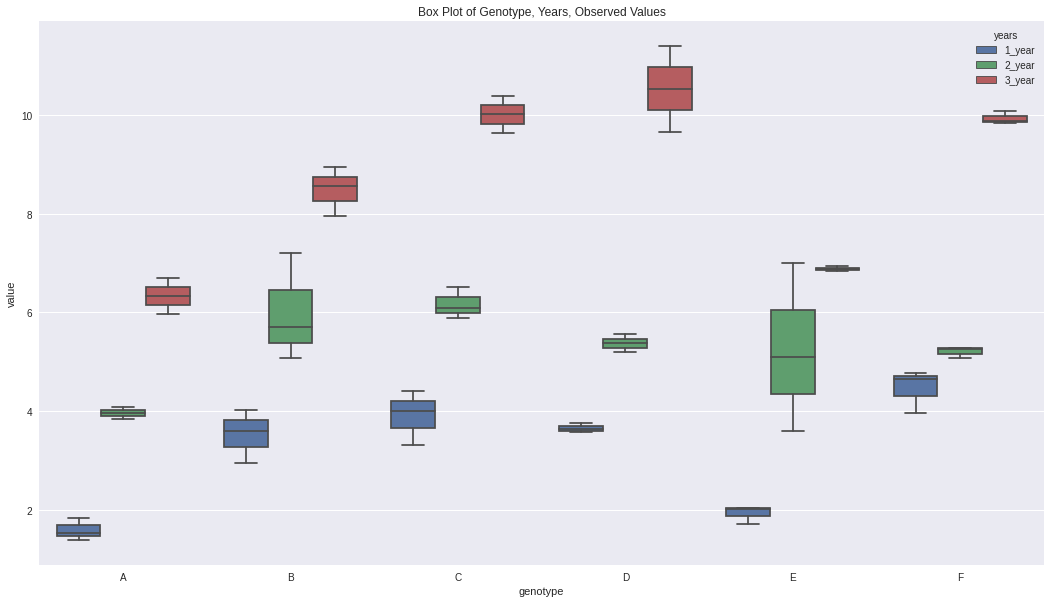

In [7]:
plt.figure(figsize = (18, 10))
sns.boxplot(x = "genotype", y = "value", hue = "years", data = melted) 
plt.title('Box Plot of Genotype, Years, Observed Values')
plt.show()

# ANOVA (Analysis Of Variance)
- We use the ANOVA to compare the means of more than two groups (since t-test can be used to compare only two groups)

-**Null Hypothesis (H0):** Groups means are equal.

-**Alternate Hypothesis (H1):**  At least, one group has the mean different from the other groups.

### Ways To Reject the null hypothesis in ANOVA Test:

<span style="color:red"> p-value > significance level (default: 0.05) </span>: Fail to reject the null hypothesis, all group means are equal.
    
<span style="color:green"> p-value < significance level (default: 0.05) </span>: Reject the null hypothesis, at least one group has the mean different from the other groups.

### Since there are two factors to evaluate we can conclude that two-way ANOVA is the most suitable method
- With this method we can evaluate simultaneously how the genotype and years affect our observed variable

### Based on the two-way ANOVA analysis will be able to test 3 hypotheses
- The effect of the 'genotype' variable on the observed variable
- The effect of the 'years' variable on the observed variable
- The effect of the 'genotype' and 'years' interactions on the observed variable

### From data we can observe that the 'genotype' variable has 6 levels and the 'years' variable has 3 levels


In [8]:
model = ols('value ~ C(genotype) + C(years) + C(genotype):C(years)', data = melted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

,sum_sq,df,F,PR(>F)
C(genotype),58.551733,5.0,32.748581,1.931655e-12
C(years),278.925633,2.0,390.014868,4.006243e-25
C(genotype):C(years),17.122967,10.0,4.788525,2.230094e-04
Residual,12.873000,36.0,NaN,NaN


# Interpretation of the results

### Based on the p-value obtained from ANOVA we can conclude the following:
- The 'genotype' variable has a statistically significant effect on the observed variable
- The 'years' variable has a statistically significant effect on the observed variable
- The interaction of both variables has a statistically significant effect on the observed variable

# Observing the Interaction Plot
## Parallel lines
- No interaction occurs

## Nonparallel lines 
- An interaction occurs, the more nonparallel the lines are then the significance of the interaction is greater

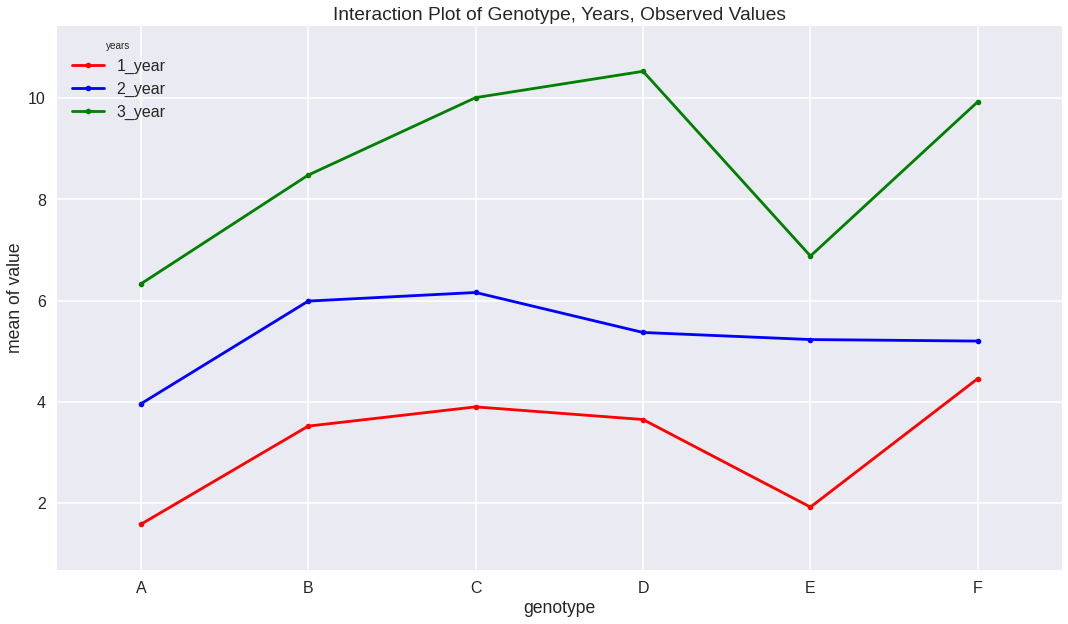

In [9]:
plt.style.use('seaborn-poster')
fig, ax = plt.subplots(figsize = (18, 10))
fig = interaction_plot(melted['genotype'], melted['years'], melted['value'], colors=['red', 'blue', 'green'], ax = ax)
plt.title('Interaction Plot of Genotype, Years, Observed Values')
plt.show()

### As we can observe from both, the ANOVA and the Interaction Plot, the interaction is quite significant

# Degrees of freedom (DF)
### Based on formulas we have:
- DF(A) = a - 1 (equivalent to 5 in our table, where A = genotype variable (number of levels in factor))
- DF(B) = b - 1 (equivalent to 2 in our table, where B = year variable (number of levels in factor))
- DF(AB) = (a - 1)(b - 1) (equivalent to 10)

Based on the previous observations we have a model with interaction, so:
DF(error) = (n - 1) - (a - 1) - (b - 1) - (a - 1)(b - 1)
where n = the number of observations (samples)

And we have DF(error) = 53 - 2 - 5 - 10 = 36 (as in the previous table from ANOVA)

# Post-hoc Analysis

# t-tests

"A t-test is a statistical test that is used to compare the means of two groups. It is often used in hypothesis testing to determine whether a process or treatment actually has an effect on the population of interest, or whether two groups are different from one another."

Source: https://www.scribbr.com/statistics/t-test/

-**Null Hypothesis (H0):** The difference in group means is zero.

-**Alternate Hypothesis (H1):**  The difference in group means is different from zero.

### Ways To Reject the null hypothesis in t-test:

<span style="color:red"> p-value > significance level (default: 0.05) </span>: Fail to reject the null hypothesis, the difference in group means is zero.
    
<span style="color:green"> p-value < significance level (default: 0.05) </span>: Reject the null hypothesis, the difference in group means is different from zero.

In [10]:
for genotype in np.unique(melted['genotype'].values):
    year_one_group   = melted[(melted['genotype'] == genotype) & (melted['years'] == '1_year')]
    year_two_group   = melted[(melted['genotype'] == genotype) & (melted['years'] == '2_year')]
    year_three_group = melted[(melted['genotype'] == genotype) & (melted['years'] == '3_year')]
    
    
    tstat, pvalue = ttest_ind(year_one_group['value'].values, year_two_group['value'].values)
    print('For genomtype: "{}" for "1_year" group and "2_year" group we have t-stat value: {} and p-value: {}' \
          .format(genotype,  np.round(tstat, 5), np.round(pvalue, 5)))
    
    tstat, pvalue = ttest_ind(year_two_group['value'].values, year_three_group['value'].values)
    print('For genomtype: "{}" for "2_year" group and "3_year" group we have t-stat value: {} and p-value: {}' \
          .format(genotype,  np.round(tstat, 5), np.round(pvalue, 5)))
    
    tstat, pvalue = ttest_ind(year_one_group['value'].values, year_three_group['value'].values)
    print('For genomtype: "{}" for "1_year" group and "3_year" group we have t-stat value: {} and p-value: {}' \
          .format(genotype,  np.round(tstat, 5), np.round(pvalue, 5)))

For genomtype: "A" for "1_year" group and "2_year" group we have t-stat value: -15.93766 and p-value: 9e-05
For genomtype: "A" for "2_year" group and "3_year" group we have t-stat value: -10.81752 and p-value: 0.00041
For genomtype: "A" for "1_year" group and "3_year" group we have t-stat value: -19.27966 and p-value: 4e-05
For genomtype: "B" for "1_year" group and "2_year" group we have t-stat value: -3.50047 and p-value: 0.02489
For genomtype: "B" for "2_year" group and "3_year" group we have t-stat value: -3.58654 and p-value: 0.02303
For genomtype: "B" for "1_year" group and "3_year" group we have t-stat value: -11.63601 and p-value: 0.00031
For genomtype: "C" for "1_year" group and "2_year" group we have t-stat value: -6.06179 and p-value: 0.00374
For genomtype: "C" for "2_year" group and "3_year" group we have t-stat value: -13.51085 and p-value: 0.00017
For genomtype: "C" for "1_year" group and "3_year" group we have t-stat value: -15.69248 and p-value: 0.0001
For genomtype: "D"

# Negative T-Value

### "A negative t-value indicates a reversal in the directionality of the effect, which has no bearing on the significance of the difference between groups."

https://sciencing.com/negative-tvalue-mean-6921215.html

### From the t-test analysis we can observe that there is a significant difference between groups

# Permutation Test

### Also called randomization tests. 

Permutation test assumes under the null hypothesis that two different groups came from the same distribution.

In [11]:
for genotype in np.unique(melted['genotype'].values):
    year_one_group   = melted[(melted['genotype'] == genotype) & (melted['years'] == '1_year')]
    year_two_group   = melted[(melted['genotype'] == genotype) & (melted['years'] == '2_year')]
    year_three_group = melted[(melted['genotype'] == genotype) & (melted['years'] == '3_year')]
    
    pvalue = permutation_test(year_one_group['value'].values, year_two_group['value'].values, method = 'approximate',
                        num_rounds = 1000, seed = SEED)
    print('For genomtype: "{}" for "1_year" group and "2_year" group we have p-value for the permutation test: {}' \
          .format(genotype, np.round(pvalue, 5)))
    
    pvalue = permutation_test(year_two_group['value'].values, year_three_group['value'].values, method = 'approximate',
                        num_rounds = 10000, seed = SEED)
    print('For genomtype: "{}" for "2_year" group and "3_year" group we have p-value for the permutation test: {}' \
          .format(genotype, np.round(pvalue, 5)))
    
    pvalue = permutation_test(year_one_group['value'].values, year_three_group['value'].values, method = 'approximate',
                        num_rounds = 10000, seed = SEED)
    
    print('For genomtype: "{}" for "1_year" group and "3_year" group we have p-value for the permutation test: {}' \
          .format(genotype,  np.round(pvalue, 5)))

For genomtype: "A" for "1_year" group and "2_year" group we have p-value for the permutation test: 0.1009
For genomtype: "A" for "2_year" group and "3_year" group we have p-value for the permutation test: 0.10299
For genomtype: "A" for "1_year" group and "3_year" group we have p-value for the permutation test: 0.10299
For genomtype: "B" for "1_year" group and "2_year" group we have p-value for the permutation test: 0.1009
For genomtype: "B" for "2_year" group and "3_year" group we have p-value for the permutation test: 0.10299
For genomtype: "B" for "1_year" group and "3_year" group we have p-value for the permutation test: 0.10299
For genomtype: "C" for "1_year" group and "2_year" group we have p-value for the permutation test: 0.1009
For genomtype: "C" for "2_year" group and "3_year" group we have p-value for the permutation test: 0.10299
For genomtype: "C" for "1_year" group and "3_year" group we have p-value for the permutation test: 0.10299
For genomtype: "D" for "1_year" group an

# Interesting, we fail to reject the null hypothesis
### So we're seeing that for each individual genotype the groups of values between each year type came from the same distribution.


## Let's try different genotypes

In [12]:
group_A = melted[(melted['genotype'] == 'A') & (melted['years'] == '1_year')]
group_B = melted[(melted['genotype'] == 'D') & (melted['years'] == '3_year')]

pvalue = permutation_test(group_A['value'].values, group_B['value'].values, method = 'approximate',
                    num_rounds = 10000, seed = SEED)

print('For genomtype "A" and "D" for "1_year" group and "3_year" group we have p-value for the permutation test: {}' \
      .format(np.round(pvalue, 5)))

For genomtype "A" and "D" for "1_year" group and "3_year" group we have p-value for the permutation test: 0.10299


# And still rejecting the null hypothesis

### Let's try to see the difference only per years and per genotype only

In [13]:
group_A = melted[(melted['years'] == '1_year')]
group_B = melted[(melted['years'] == '3_year')]

pvalue = permutation_test(group_A['value'].values, group_B['value'].values, method = 'approximate',
                    num_rounds = 10000, seed = SEED)

print('For "1_year" group and "3_year" group we have p-value for the permutation test: {}' \
      .format(np.round(pvalue, 5)))

For "1_year" group and "3_year" group we have p-value for the permutation test: 0.0001


In [14]:
group_A = melted[(melted['genotype'] == 'A')]
group_B = melted[(melted['genotype'] == 'D')]

pvalue = permutation_test(group_A['value'].values, group_B['value'].values, method = 'approximate',
                    num_rounds = 10000, seed = SEED)

print('For "A" genotype group and "F" genotype group we have p-value for the permutation test: {}' \
      .format(np.round(pvalue, 5)))

For "A" genotype group and "F" genotype group we have p-value for the permutation test: 0.06129


### Now we can reject the null hypothesis concluding that our groups came from different distributions

#  Additional hypothesis testing

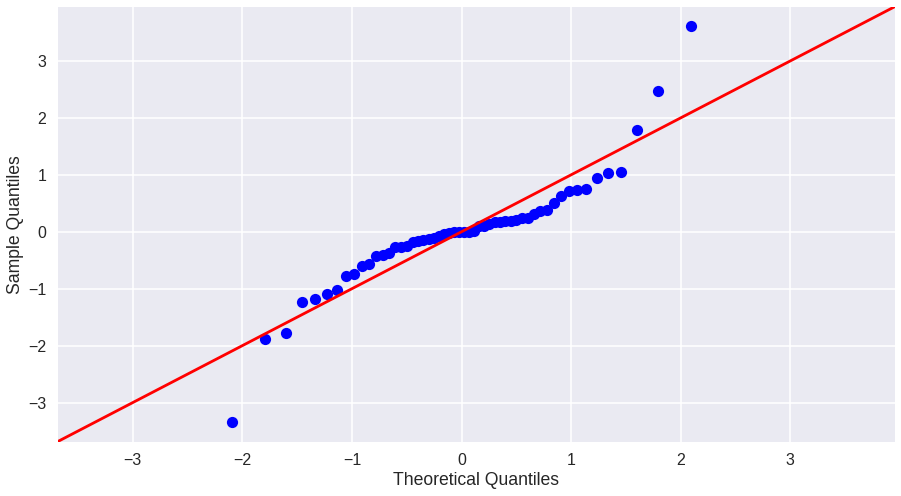

In [15]:
fig, ax = plt.subplots(figsize = (15, 8))
sm.qqplot(model.resid, fit=True, line="45", ax = ax)
plt.show()

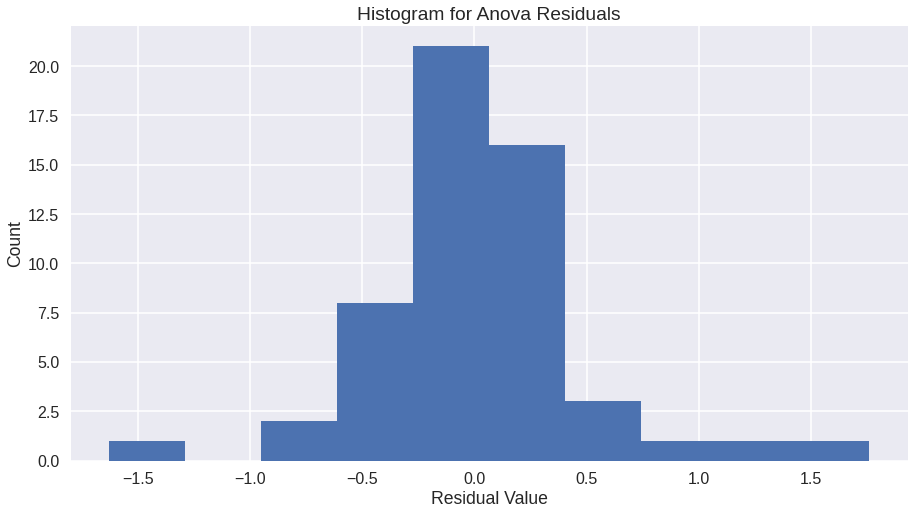

In [16]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.hist(model.resid)
plt.title('Histogram for Anova Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.show()

# Shapiro-Wilk Test for Normality
### Null hypothesis: data is drawn from normal distribution.

In [17]:
w, pvalue = stats.shapiro(model.resid)
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Shapiro-Wilk Test Results, W: 0.8979, p-value: 0.0002


### Even if our distribution looks like a normal distribution we reject the null hypothesis

- We conclude that our residuals did not come from a normal distribution (based on this sample size)

# Homogeneity of variances 
### Null hypothesis: variances are equal between groups

For that we can use Levene’s or Bartlett’s Test depending it our data is normal or not

In [18]:
w, pvalue = stats.shapiro(data['1_year'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

w, pvalue = stats.shapiro(data['2_year'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

w, pvalue = stats.shapiro(data['3_year'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Shapiro-Wilk Test Results, W: 0.905, p-value: 0.0704
Shapiro-Wilk Test Results, W: 0.9528, p-value: 0.4709
Shapiro-Wilk Test Results, W: 0.9098, p-value: 0.0855


In [19]:
w, pvalue = stats.bartlett(data['1_year'], data['2_year'], data['3_year'])
print("Barlett's Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Barlett's Test Results, W: 5.1882, p-value: 0.0747


# It seems that the variance between the year groups it's not equal

In [20]:
w, pvalue = stats.shapiro(melted[melted['genotype'] == 'A']['value'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

w, pvalue = stats.shapiro(melted[melted['genotype'] == 'B']['value'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

w, pvalue = stats.shapiro(melted[melted['genotype'] == 'C']['value'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

w, pvalue = stats.shapiro(melted[melted['genotype'] == 'D']['value'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

w, pvalue = stats.shapiro(melted[melted['genotype'] == 'E']['value'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

w, pvalue = stats.shapiro(melted[melted['genotype'] == 'F']['value'])
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Shapiro-Wilk Test Results, W: 0.8918, p-value: 0.2081
Shapiro-Wilk Test Results, W: 0.9269, p-value: 0.4528
Shapiro-Wilk Test Results, W: 0.8923, p-value: 0.2108
Shapiro-Wilk Test Results, W: 0.8258, p-value: 0.0401
Shapiro-Wilk Test Results, W: 0.8075, p-value: 0.0248
Shapiro-Wilk Test Results, W: 0.7496, p-value: 0.0054


In [21]:
w, pvalue = stats.bartlett(melted[melted['genotype'] == 'A']['value'], melted[melted['genotype'] == 'B']['value'], melted[melted['genotype'] == 'C']['value'])
print("Barlett's Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

w, pvalue = stats.levene(melted[melted['genotype'] == 'D']['value'], melted[melted['genotype'] == 'E']['value'], melted[melted['genotype'] == 'F']['value'])
print("Levene's Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Barlett's Test Results, W: 0.5798, p-value: 0.7483
Levene's Test Results, W: 0.1494, p-value: 0.862


## As expected the variance between the genotype groups it's not equal either

# Linear Regression
\begin{equation}
\hat{y} = \beta_{0} + \beta_{1}X_{1} + \dots + \beta_{n}X_{n}
\end{equation}

- $\hat{y}$   - the dependent variable
- $X_{n}$     - the independent variables
- $\beta_{0}$ - the intercept
- $\beta_{n}$ - the slope for the variable $X_{n}$

# Loading the data and Exploratory Data Analysis

In [22]:
PATH_TO_REGRESSION_DATA = 'data/howell.txt'
dataset = pd.read_csv(PATH_TO_REGRESSION_DATA, sep = ';')
display(dataset)

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
539,145.415,31.127751,17.0,1
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0
542,71.120,8.051258,0.0,1


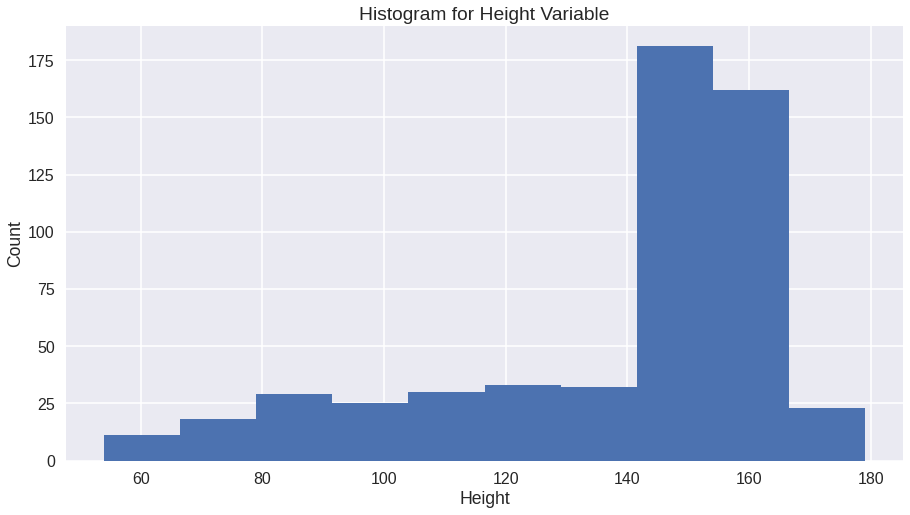

In [23]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.hist(dataset['height'])
plt.title('Histogram for Height Variable')
plt.xlabel('Height')
plt.ylabel('Count')
plt.show()

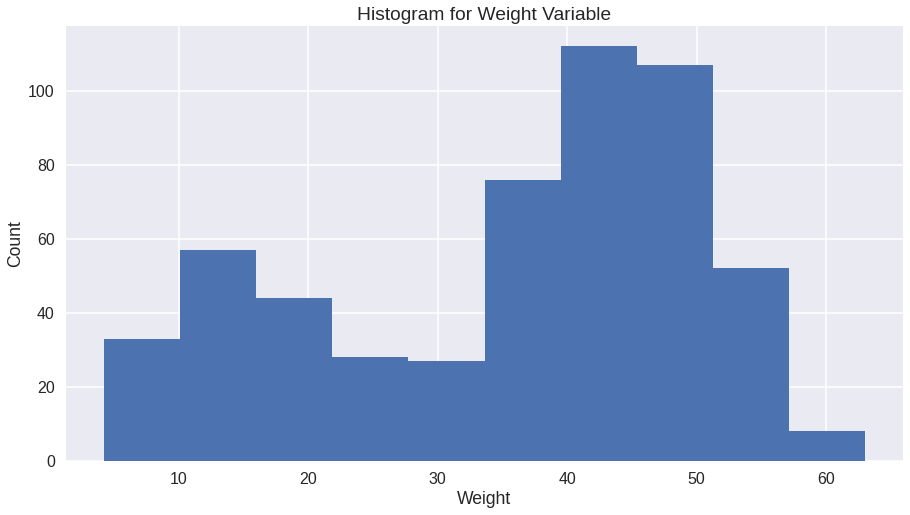

In [24]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.hist(dataset['weight'])
plt.title('Histogram for Weight Variable')
plt.xlabel('Weight')
plt.ylabel('Count')
plt.show()

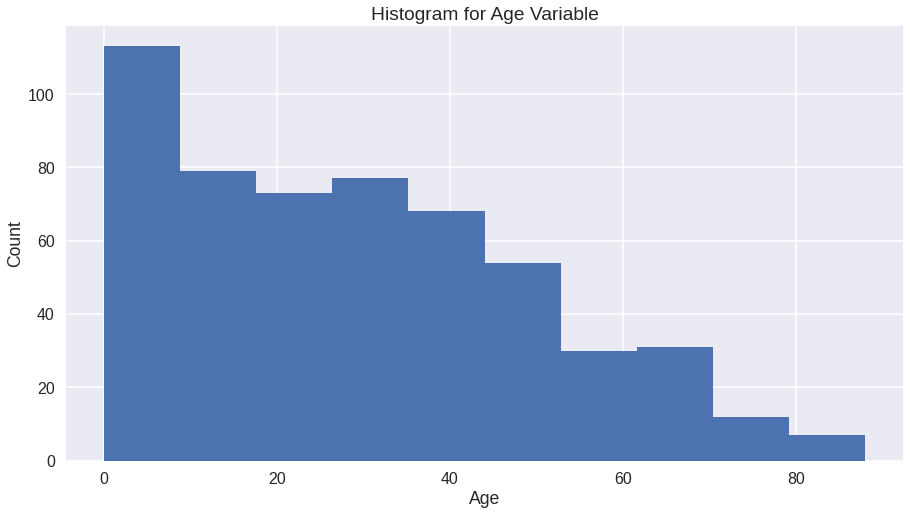

In [25]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.hist(dataset['age'])
plt.title('Histogram for Age Variable')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [26]:
display(dataset[dataset['age'] == 0])

,height,weight,age,male
406,69.850,7.314171,0.0,0
408,67.945,7.824462,0.0,1
415,68.580,8.022908,0.0,0
455,66.675,8.136306,0.0,0
456,62.865,7.200773,0.0,1
462,62.230,7.257472,0.0,0
466,55.880,4.847765,0.0,0
467,60.960,6.236890,0.0,1
517,53.975,4.252425,0.0,0
519,56.515,5.159609,0.0,0


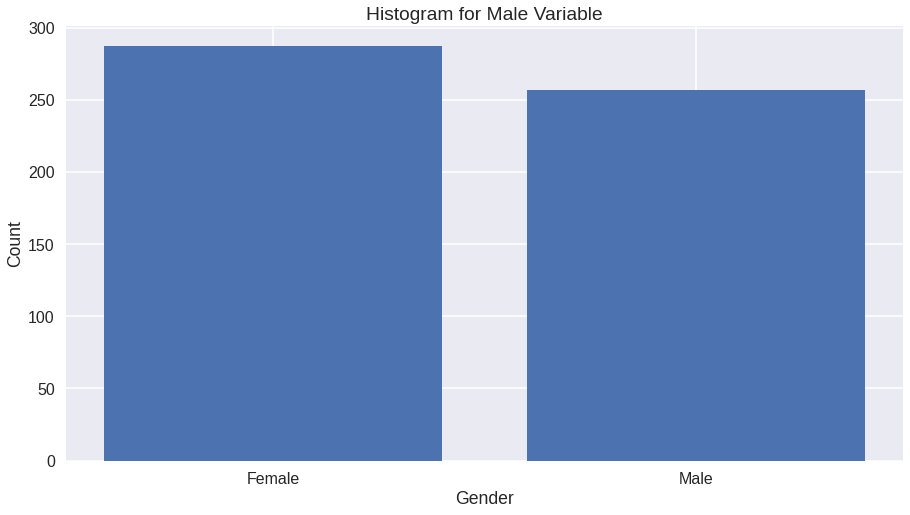

In [27]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.bar(*np.unique(dataset['male'], return_counts = True))
plt.title('Histogram for Male Variable')
plt.xticks([0, 1], ['Female', 'Male'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

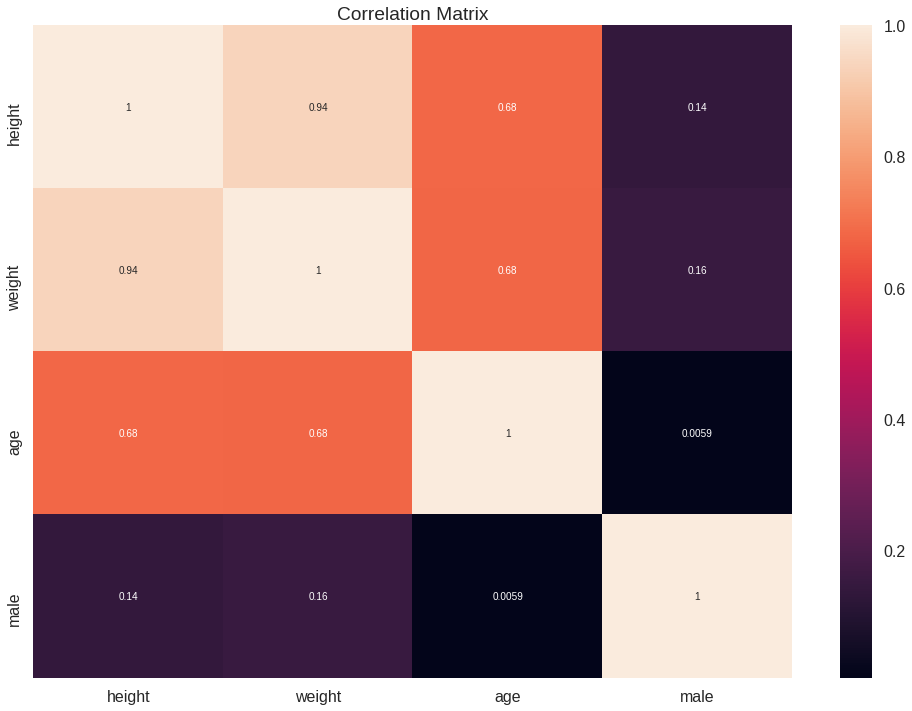

In [28]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (17, 12))
plt.title('Correlation Matrix')
sns.heatmap(dataset.corr(), annot = True)
plt.show()

### As we can see there is a strong level of correlation between the variables 'height', 'weight' and 'age'
- Based on that fact we can use as target variable the variable 'height'

# Baseline Regression 

### In this part we will implement a baseline regression just to be sure that our dataset is suitable for this task

To decide that we will use $R^{2}$ score and plot of the residuals, those concepts will be later explained in a more in-depth analysis after this 'validation' step

In [29]:
X = dataset[['weight', 'age', 'male']].values
y = dataset['height'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R^2 Score on validation set: {}".format(r2_score(y_pred, y_test)))

dataset['sk_height_estimation'] = model.predict(X)
dataset['sk_residuals'] = dataset['height'] - dataset['sk_height_estimation']
dataset['sk_squared_residuals'] = (dataset['height'] - dataset['sk_height_estimation']) ** 2

display(dataset)

R^2 Score on validation set: 0.8982562342149657


,height,weight,age,male,sk_height_estimation,sk_residuals,sk_squared_residuals
0,151.765,47.825606,63.0,1,162.652579,-10.887579,118.539372
1,139.700,36.485807,63.0,0,143.341121,-3.641121,13.257764
2,136.525,31.864838,65.0,0,135.876996,0.648004,0.419910
3,156.845,53.041914,41.0,1,168.953631,-12.108631,146.618941
4,145.415,41.276872,51.0,0,150.011703,-4.596703,21.129677
...,...,...,...,...,...,...,...
539,145.415,31.127751,17.0,1,129.952588,15.462412,239.086178
540,162.560,52.163080,31.0,1,166.416917,-3.856917,14.875810
541,156.210,54.062497,21.0,0,168.030869,-11.820869,139.732941
542,71.120,8.051258,0.0,1,89.773279,-18.653279,347.944820


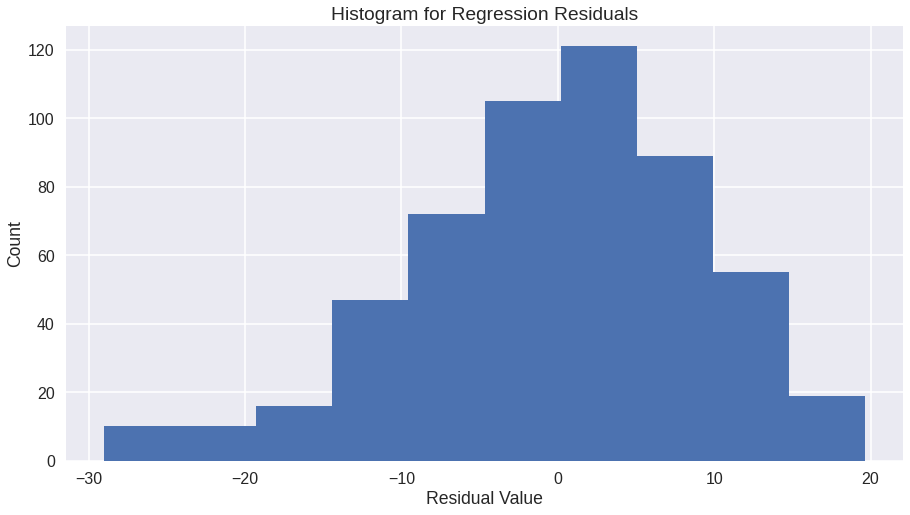

In [30]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.hist(dataset['sk_residuals'])
plt.title('Histogram for Regression Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.show()

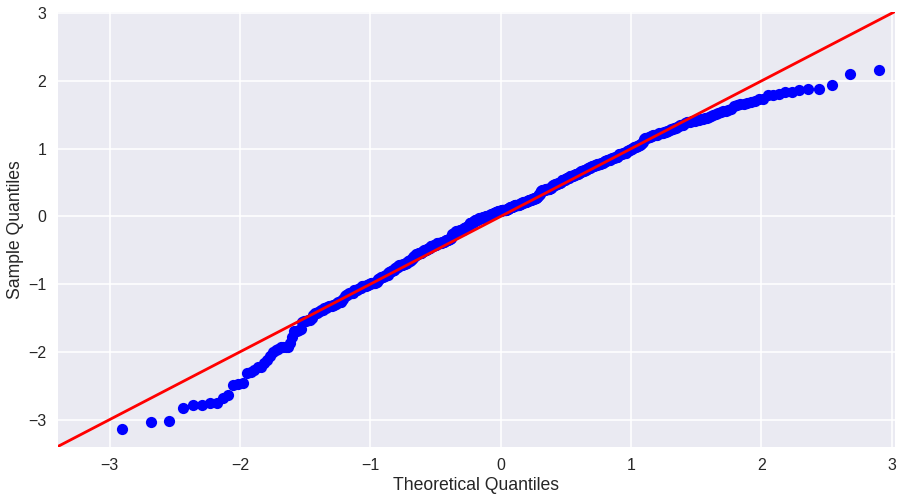

In [31]:
fig, ax = plt.subplots(figsize = (15, 8))
sm.qqplot(dataset['sk_residuals'], fit=True, line="45", ax = ax)
plt.show()

# As we can observe the baseline results are quite good
- Based on that we can use this dataset for this task in a more in-depth analysis

# In-depth analysis of Linear Regression
- For that will be easier for us to change from skikit-learn to statsmodels

# For this analysis we need some intuition for the following concepts:
### $R^{2}$,  $R^{2}_{adjusted}$ and Beta Coefficients

# The coefficient of determination ($R^{2}$)

The mathematical formulation of this concept is the following:

\begin{equation}
R^{2} = 1 - \frac{SS_{res}}{SS_{tot}}
\end{equation}

where 

\begin{equation}
SS_{res} = \sum_{i = 1}^{N}(y_{i} - \hat{y}_{i})^{2}
\end{equation}

and 

\begin{equation}
SS_{tot} = \sum_{i = 1}^{N}(y_{i} - \overline{y}_{i})^{2}
\end{equation}

### In a more informal manner $R^{2}$ represents the proportion of variance of y that can be explained by X

As values for $R^2$ we can consider the following:

"Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a $R^2$ score of 0.0."

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

# Adjusted R-squared

As the name suggests, Adjusted R-squared represents a slightly variation of $R^2$ that takes into consideration the number of predictors.

(independent variables X used to predict y)


\begin{equation}
R^{2}_{adjusted} = 1 - \frac{(1 - R^2)(N - 1)}{N - p - 1}
\end{equation}
where p = the number of predictors


### We will explain the Beta Coefficients based on our dataset

# With those concepts in mind, we can fit and analyze a LinearRegression 

In [32]:
X_train = sm.add_constant(X_train)
X_test  = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)

model_fit = model.fit()
y_pred    = model_fit.predict(X_test)

print("R^2 Score on validation set: {}".format(r2_score(y_pred, y_test)))

R^2 Score on validation set: 0.8982562342149664


In [33]:
model_fit.summary().tables[0]

Dep. Variable:,y,R-squared:,0.884
Model:,OLS,Adj. R-squared:,0.883
Method:,Least Squares,F-statistic:,1096.
Date:,"Tue, 08 Jun 2021",Prob (F-statistic):,2.94e-201
Time:,16:12:07,Log-Likelihood:,-1590.0
No. Observations:,435,AIC:,3188.
Df Residuals:,431,BIC:,3204.
Df Model:,3,,
Covariance Type:,nonrobust,,


In [34]:
model_fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,75.9269,1.215,62.508,0.000,73.539,78.314
x1,1.6619,0.044,37.974,0.000,1.576,1.748
x2,0.1076,0.031,3.497,0.001,0.047,0.168
x3,0.4664,0.923,0.505,0.614,-1.348,2.281


# Beta Coefficients

- 'const' term represents the intercept
- 'x1' represents the slope for the height variable
- 'x2' represents the slope for the age variable
- 'x3' represents the slope for the male variable

A very important estimator for each coefficient it's the $P > |t|$ the p-value.
For each Beta Coefficient it's associated a hypothesis test stating as null hypothesis that the coefficient is 0, and therefore not significant in explaining the dependent variable y.

To reject that hypothesis, resulting that our coefficient is significant in explaining y, we need that the associated p-value to be less than 0.05.

# Summary of Analysis
### For this analysis we will use as estimators of performance:
- A high $R^2$ and $R^2_{adjusted}$
- The $P > |t|$ of each hypothesis test associated to beta coefficients to be less than 0.05
- The analysis for normality of residuals (Shapiro-Wilk test)

### We can observe that for the 'male' variable we cannot reject the null hypothesis
### Based on this we might remove the variable from the set of predictors

In [35]:
X = dataset[['weight', 'age']].values
y = dataset['height'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

X_train = sm.add_constant(X_train)
X_test  = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)

model_fit = model.fit()
y_pred    = model_fit.predict(X_test)

print("R^2 Score on validation set: {}".format(r2_score(y_pred, y_test)))

R^2 Score on validation set: 0.8988846423369699


In [36]:
model_fit.summary().tables[0]

Dep. Variable:,y,R-squared:,0.884
Model:,OLS,Adj. R-squared:,0.884
Method:,Least Squares,F-statistic:,1647.
Date:,"Tue, 08 Jun 2021",Prob (F-statistic):,7.29e-203
Time:,16:12:07,Log-Likelihood:,-1590.1
No. Observations:,435,AIC:,3186.
Df Residuals:,432,BIC:,3198.
Df Model:,2,,
Covariance Type:,nonrobust,,


In [37]:
model_fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,76.0408,1.193,63.765,0.000,73.697,78.385
x1,1.6663,0.043,38.885,0.000,1.582,1.750
x2,0.1057,0.031,3.464,0.001,0.046,0.166


### From the $R^{2}$  on the validation set and $R^{2}_{adjusted}$ we can observe that the second model is better

# Residual Analysis

In [38]:
residuals = model_fit.resid

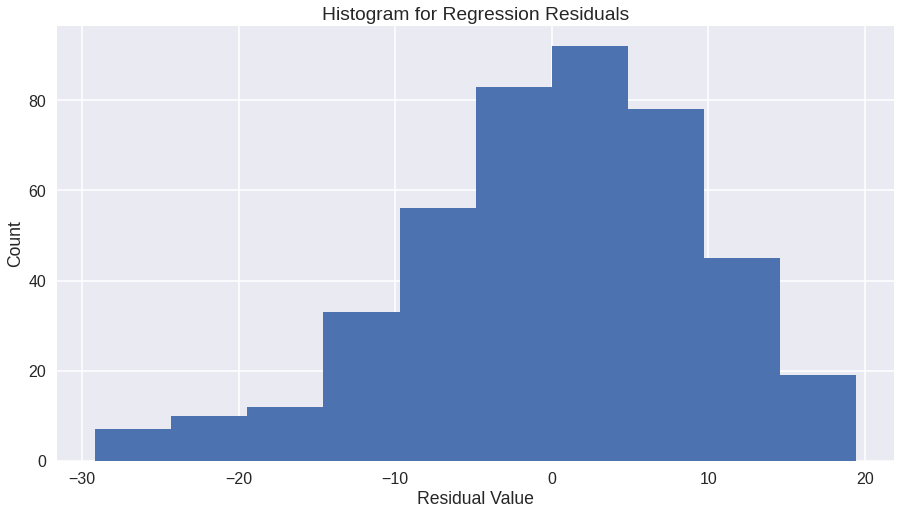

In [39]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.title('Histogram for Regression Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.hist(residuals)
plt.show()

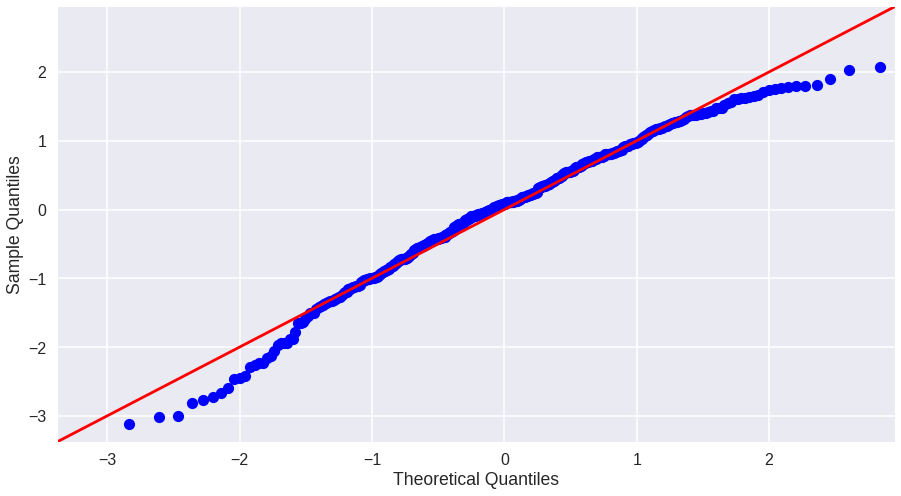

In [40]:
fig, ax = plt.subplots(figsize = (15, 8))
sm.qqplot(residuals, fit = True, line="45", ax = ax)
plt.show()

# Testing for Normality and Homogeneity of Variance
### For that we will use:
- Shapiro-Wilk test: used to verify the normal distribution of residuals.

Null hypothesis: data is drawn from normal distribution.

- Bartlett’s test: used to verify the homogeneity of variances. 

Null hypothesis: samples from populations have equal variances.

In [41]:
w, pvalue = stats.shapiro(residuals)
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

group_1 = [pred for pred in residuals if pred <  residuals.mean()]
group_2 = [pred for pred in residuals if pred >= residuals.mean()]

w, pvalue = stats.bartlett(group_1, group_2)
print("Barlett's Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Shapiro-Wilk Test Results, W: 0.9792, p-value: 0.0
Barlett's Test Results, W: 24.9719, p-value: 0.0


## We rejected the null hypothesis in both case, that's not good
### It seems that our residuals are not normally distributed
### And the lower half of our predictions have different variance from the upper half

# Maybe we can find a better regression model
### Let's try a non-linear model for this problem

In [42]:
pm = PolynomialFeatures(degree = 2, include_bias = False)
X = dataset[['weight', 'age']].values
X = pm.fit_transform(X)
y = dataset['height'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

X_train = sm.add_constant(X_train)
X_test  = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)

model_fit = model.fit()
y_pred    = model_fit.predict(X_test)

print("R^2 Score on validation set: {}".format(r2_score(y_pred, y_test)))

R^2 Score on validation set: 0.9608121215906972


In [43]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1840.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):          3.36e-287
Time:                        16:12:08   Log-Likelihood:                -1382.1
No. Observations:                 435   AIC:                             2776.
Df Residuals:                     429   BIC:                             2801.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3159      1.692     26.189      0.000      40.990      47.642
x1             4.3442      0.177     24.558      0.000       3.996       4.692
x2            -0.0076      0.144     -0.053      0.958      -0.290       0.275
x3            -0.0395      0.003    -13.229      0.000      -0.045      -0.034
x4            -0.0024      0.003     -0.809      0.419      -0.008       0.003
x5             0.0009      0.001      0.824      0.410      -0.001       0.003
==============================================================================
Omnibus:                        0.560   Durbin-Watson:                   2.126
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.581
Skew:                          -0.087   Prob(JB):                        0.748
Kurtosis:                       2.954   Cond. No.                     1.75e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# We can observe that features that contain the 'age' variable tend to be 0
### Maybe we can predict the height only based on the 'weight' variable
### Let's try to visualize them

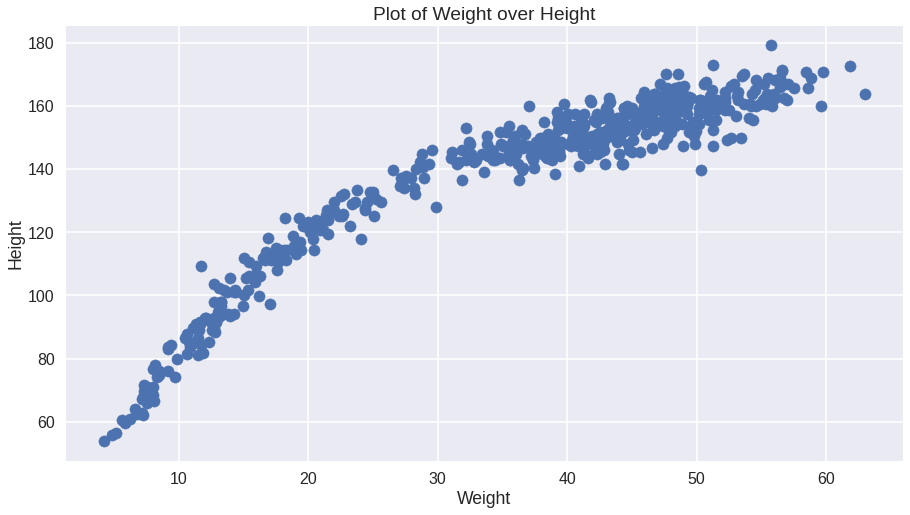

In [44]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.scatter(dataset['weight'], dataset['height'])
plt.title("Plot of Weight over Height")
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

# It seems there is a strong relation between a "Weight" and "Height"
### Maybe we can model this relation base on a second or third degree regression

In [45]:
pm = PolynomialFeatures(degree = 3, include_bias = False)

X = pm.fit_transform(dataset['weight'].values.reshape(-1, 1))
y = dataset['height'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

X_train = sm.add_constant(X_train)
X_test  = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train)

model_fit = model.fit()
y_pred    = model_fit.predict(X_test)

print("R^2 Score on validation set: {}".format(r2_score(y_pred, y_test)))

R^2 Score on validation set: 0.9780711592233222


In [46]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     4204.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):          1.19e-318
Time:                        16:12:08   Log-Likelihood:                -1317.1
No. Observations:                 435   AIC:                             2642.
Df Residuals:                     431   BIC:                             2659.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.8741      2.183     10.018      0.000      17.583      26.166
x1             7.3738      0.260     28.331      0.000       6.862       7.885
x2            -0.1475      0.009    -16.942      0.000      -0.165      -0.130
x3             0.0011   8.78e-05     12.446      0.000       0.001       0.001
==============================================================================
Omnibus:                        6.175   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                8.365
Skew:                          -0.085   Prob(JB):                       0.0153
Kurtosis:                       3.658   Cond. No.                     7.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
residuals = model_fit.resid

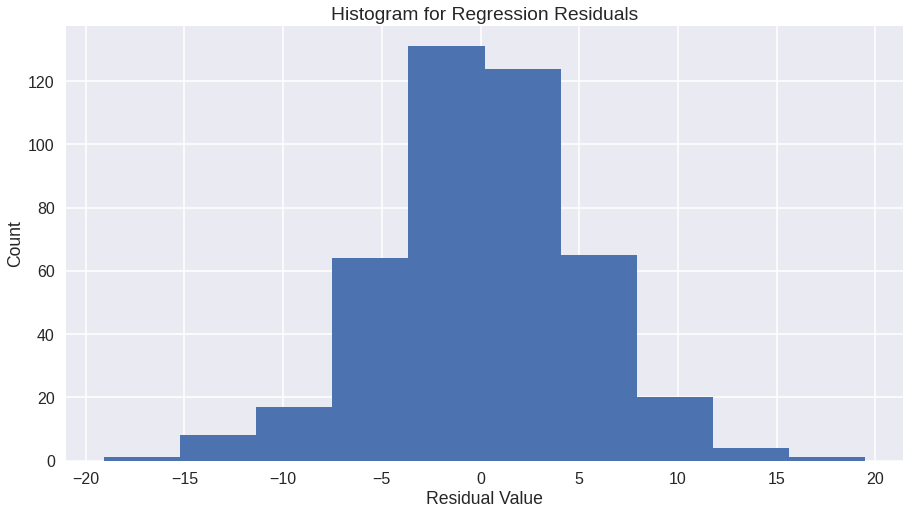

In [48]:
plt.style.use('seaborn-poster')
plt.figure(figsize = (15, 8))
plt.title('Histogram for Regression Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.hist(residuals)
plt.show()

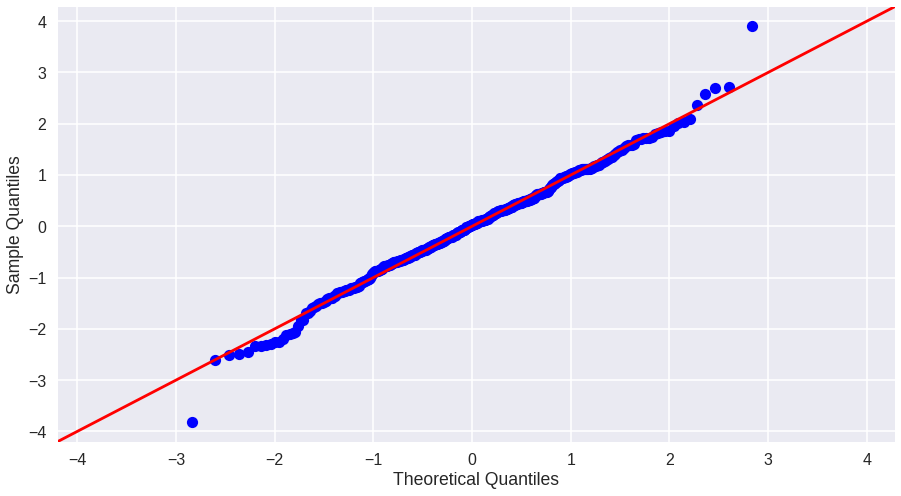

In [49]:
fig, ax = plt.subplots(figsize = (15, 8))
sm.qqplot(residuals, fit = True, line="45", ax = ax)
plt.show()

In [50]:
w, pvalue = stats.shapiro(residuals)
print("Shapiro-Wilk Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

group_1 = [pred for pred in residuals if pred <  residuals.mean()]
group_2 = [pred for pred in residuals if pred >= residuals.mean()]

w, pvalue = stats.bartlett(group_1, group_2)
print("Barlett's Test Results, W: {}, p-value: {}".format(np.round(w, 4), np.round(pvalue, 4)))

Shapiro-Wilk Test Results, W: 0.9943, p-value: 0.1044
Barlett's Test Results, W: 0.4791, p-value: 0.4888


# Anova over regression model

In [51]:
anova_dataset = pd.DataFrame(X, columns = ['weight_1', 'weight_2', 'weight_3'])
anova_dataset['height'] = dataset['height']
display(anova_dataset)

model = ols('height ~ C(weight_1) + C(weight_2) + C(weight_3)', data = anova_dataset).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
display(anova_table)

,weight_1,weight_2,weight_3,height
0,47.825606,2287.288637,109390.966310,151.765
1,36.485807,1331.214076,48570.419185,139.700
2,31.864838,1015.367901,32354.533668,136.525
3,53.041914,2813.444694,149230.492900,156.845
4,41.276872,1703.780162,70326.715667,145.415
...,...,...,...,...
539,31.127751,968.936882,30160.826008,145.415
540,52.163080,2720.986915,141935.058131,162.560
541,54.062497,2922.753528,158011.352368,156.210
542,8.051258,64.822755,521.904728,71.120


,sum_sq,df,F,PR(>F)
C(weight_1),411678.353037,456.0,38.678336,5.131520e-51
C(weight_2),411678.353037,456.0,38.678336,5.131520e-51
C(weight_3),411678.353037,456.0,38.678336,5.131520e-51
Residual,2030.694816,87.0,NaN,NaN


# This seems to be a better regression model
- Based on $R^2$, $R^2_{adjusted}$, beta coefficients, normality of the residuals